Recently wildfire smoke has returned and blanketed the city in haze, causing the air quality health index (AQHI) to sky rocket, and as a result I've been spending a lot more time inside. This feels like it is a lot more common event than it used to be, but I'm not sure if that's true or if it merely feels true because I'm looking out at a hazy skyline.

I would like to look into this more using air quality data and see if this truly is a recent change, or maybe Edmonton has always been like this and I've simply forgotten.

## Particulates as a proxy

Alberta has a series of air quality monitoring stations set up around the province and I can pull a data-set from the Edmonton Central station (the closest one to me) and look at airborne particulates (pm2.5) as a proxy for wildfire smoke. Though the smoke itself is more than just particulates &lt;2.5μm in diameter, it is those particulates that cause the AQHI to rise significantly.

However there are more sources of pm2.5 than just wildfires, vehicles are a major source for one, and in the winter atmospheric inversions can lead to really poor air quality during which time the pm2.5 concentration rises. Additionally farmers around the city often burn stubble and other stuff in the fall, leading to smoke days that have nothing to do with wildfires.

So this is a proxy for wildfire smoke, but not a great one.

### Ambient Air Data

I downloaded just the pm2.5 measurements for Edmonton Central from October 2000, the earliest reported values, through to the end of December 2020, the latest values in the database at this time, from [Alberta's Ambient Air Data Warehouse](https://airdata.alberta.ca/reporting/Download/MultipleParameters). This is a csv with 177,072 rows of data and several columns each corresponding to, I'm guessing, a different instrument. Over time the station has swapped out instruments for measuring pm2.5s and those are recorded as a different measurement type.

In [1]:
using CSV, DataFrames, Dates, Pipe, Plots

In [2]:
data_file = "data/Long Term pm2.5 Edmonton Central.csv"

ambient_data = @pipe data_file |>
    CSV.File( _ ; 
             dateformat="mm/dd/yyyy HH:MM:SS", 
             types=[DateTime, DateTime, Float64, Float64, Float64, Float64], 
             header=16, silencewarnings=true) |>
    DataFrame(_);


In [3]:
#| echo: false
println(summary(ambient_data))

show(first(ambient_data, 6), allcols=true)

177072×6 DataFrame
6×6 DataFrame
 Row │ IntervalStart        IntervalEnd          MeasurementValue  MeasurementValue_1  MeasurementValue_2  MeasurementValue_3 
     │ DateTime             DateTime             Float64?          Float64?            Float64?            Float64?           
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 2000-10-20T00:00:00  2000-10-20T00:59:00           missing             missing             missing                 2.3
   2 │ 2000-10-20T01:00:00  2000-10-20T01:59:00           missing             missing             missing                 1.8
   3 │ 2000-10-20T02:00:00  2000-10-20T02:59:00           missing             missing             missing                 1.8
   4 │ 2000-10-20T03:00:00  2000-10-20T03:59:00           missing             missing             missing                 1.0
   5 │ 2000-10-20T04:00:00  2000-10-20T04:59:00           missing             miss

### Parsing the Data

What I want to know is when smoke events happened and how long they were. To estimate that I am going to assume a smoke event is a period in which the hourly pm2.5 exceed the ambient air quality guideline for pm2.5s. The event starts at the first hour greater than that limit and ends on the first hour less than that limit. This has the obvious weakness that sometimes the clouds of wildfire smoke has breaks in it, so what feels like a week long smoke event would end up as a series of smaller events as the pm2.5 count might dip overnight or something. But this is a start.

One complication is that the dataset has four columns of pm2.5 data that are full of mostly missing values since they each only correspond to the period in which the given instrument is running. So I first need to collect those measurement values, drop the missing values, and take the mean of what remains. I assume there is no overlap and so it's the mean of one number, but I haven't checked to see if that's true and the mean seems like the most sensible thing to do if there is overlap.

If there is a missing hour entirely, i.e. no instrument has a reading, then I skip it. That neither counts as the start nor the end of a smoke event and I move to the next row.

In [4]:
#| output: false
using Statistics

lim_1h = 80.0  #μg/m³ 1-hr limit
lim_24h = 29.0 #μg/m³ 24-hr limit

function exceedences(df; limit=lim_1h)

    results = DataFrame(start_date = DateTime[], end_date = DateTime[], month = Int64[], year = Int64[], duration = Float64[], max_conc = Float64[])

    flag = false
    start_date = nothing
    end_date = nothing
    max_conc = 0.0

    for r in eachrow(ambient_data)
        measurements = [r[:MeasurementValue], r[:MeasurementValue_1], r[:MeasurementValue_2], r[:MeasurementValue_3]]
        measurements = collect( skipmissing(measurements) )
        conc = if (sizeof(measurements)>0) mean(measurements) else missing end

        if typeof(conc) == Missing
            # ignore missing data
        elseif conc > limit
            if flag == true            # we are already in a sequence
                end_date = r[:IntervalEnd]
                max_conc = max(conc, max_conc)
            else                       # we are starting a sequence
                flag = true
                start_date = r[:IntervalStart]
                end_date = r[:IntervalEnd]
                max_conc = max(conc, max_conc)
            end
        else
            if flag == true           # we are ending a sequence
                flag = false
                duration = Dates.value.(end_date - start_date)/3.6e6
                push!(results, [start_date, end_date, month(start_date), year(start_date), duration, max_conc])
                max_conc = 0.0
            end
        end
    end
    
    return results
end

exceedences (generic function with 1 method)

In [5]:
#| output: false
result_1hr = exceedences(ambient_data, limit=lim_1h)

,start_date,end_date,month,year,duration,max_conc
,DateTime,DateTime,Int64,Int64,Float64,Float64
1,2001-05-24T11:00:00,2001-05-24T12:59:00,5,2001,1.98333,274.8
2,2001-09-20T20:00:00,2001-09-20T20:59:00,9,2001,0.983333,88.5
3,2002-01-30T18:00:00,2002-01-30T20:59:00,1,2002,2.98333,111.5
4,2002-05-20T20:00:00,2002-05-20T23:59:00,5,2002,3.98333,293.3
5,2002-05-23T00:00:00,2002-05-23T04:59:00,5,2002,4.98333,200.5
6,2003-12-10T09:00:00,2003-12-10T09:59:00,12,2003,0.983333,82.3
7,2004-02-25T13:00:00,2004-02-25T13:59:00,2,2004,0.983333,86.3
8,2004-02-25T16:00:00,2004-02-25T18:59:00,2,2004,2.98333,99.6
9,2006-07-06T00:00:00,2006-07-06T02:59:00,7,2006,2.98333,83.2


In [6]:
#| echo: false
println("Results: " * summary(result_1hr))
println()
println("Summary: ")
show(describe(result_1hr))

Results: 53×6 DataFrame

Summary: 
6×7 DataFrame
 Row │ variable    mean     min                  median   max                  ⋯
     │ Symbol      Union…   Any                  Union…   Any                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ start_date           2001-05-24T11:00:00           2019-05-31T15:00:00  ⋯
   2 │ end_date             2001-05-24T12:59:00           2019-05-31T15:59:00
   3 │ month       5.84906  1                    7.0      12
   4 │ year        2011.15  2001                 2010.0   2019
   5 │ duration    3.85126  0.983333             1.98333  26.9833              ⋯
   6 │ max_conc    135.9    80.3                 93.9     867.0
                                                               2 columns omitted

Over the past 20yrs there were 53 periods with the pm2.5 concentration above the limit, these range from 1hr to 27hrs long and a max concentration observed of 867μg/m³

## Results

A plot of the results, showing each period in excess of the hourly limit and the duration of that period, is very suggestive that these are becoming more frequent events. If we also plot the maximum hourly concentration observed it appears that the extreme smoke days are a more recent phenomenon. Though with the big caveat that the data only goes back 20 years, it could be that the period between 2000 and 2010 was an abnormally smoke-less period.

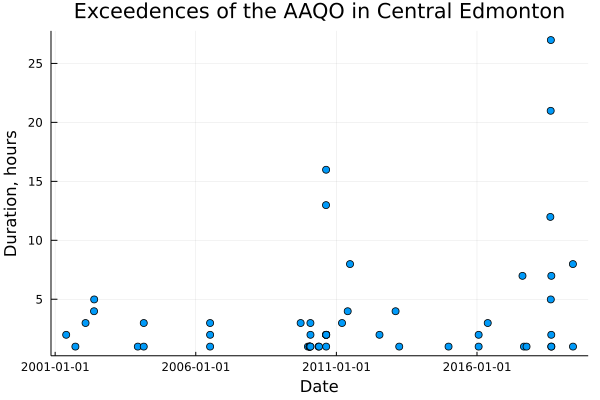

In [7]:
#| echo: false
#| label: fig-duration
#| fig-cap: "Duration of AAQO exceedances in Edmonton from 2001 through 2019"
plot(result_1hr.start_date, result_1hr.duration, lab=false,
     title="Exceedences of the AAQO in Central Edmonton",
     seriestype = :scatter,
     ylabel="Duration, hours",
     xlabel="Date",
     legend=:left)

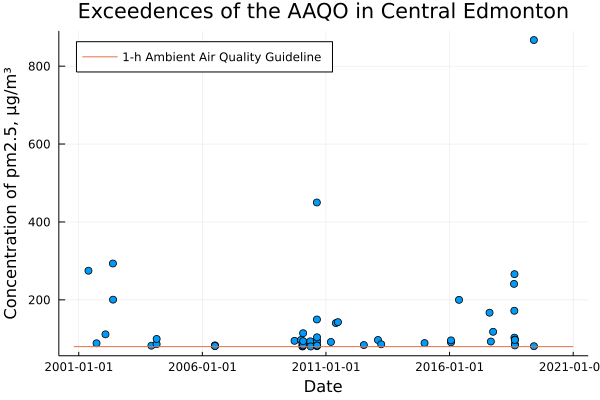

In [8]:
#| echo: false
#| label: fig-concentration
#| fig-cap: "Observed concentrations for AAQO exceedances in Edmonton, 2001 through 2019"

plot(result_1hr.start_date, result_1hr.max_conc, lab=false,
     title="Exceedences of the AAQO in Central Edmonton",
     seriestype = :scatter,
     ylabel="Concentration of pm2.5, μg/m³",
     xlabel="Date",
     legend=:topleft)
plot!([ambient_data.IntervalStart[1], ambient_data.IntervalStart[end]], 
      [lim_1h, lim_1h], lab="1-h Ambient Air Quality Guideline")

The plots below aggregate the events by year, and it certainly seems like smoke events are becoming more frequent and lasting longer, with more time spent in haze than in the early 2000s. But there are notable years such as 2010 and 2018 which could simply be outliers. Interestingly the most notable, in the news, years for wildfires are not obvious ones here -- the Slave Lake fire of 2011 and Ft. McMurray fire of 2016. I think it is often the case that the wildfire smoke in Alberta has less to do with fires in Alberta itself and more to do with smoke being carried in from neighbouring states and provinces. That is certainly true now when the major wildfires are in BC, northern Saskatchewan, and northern Manitoba.

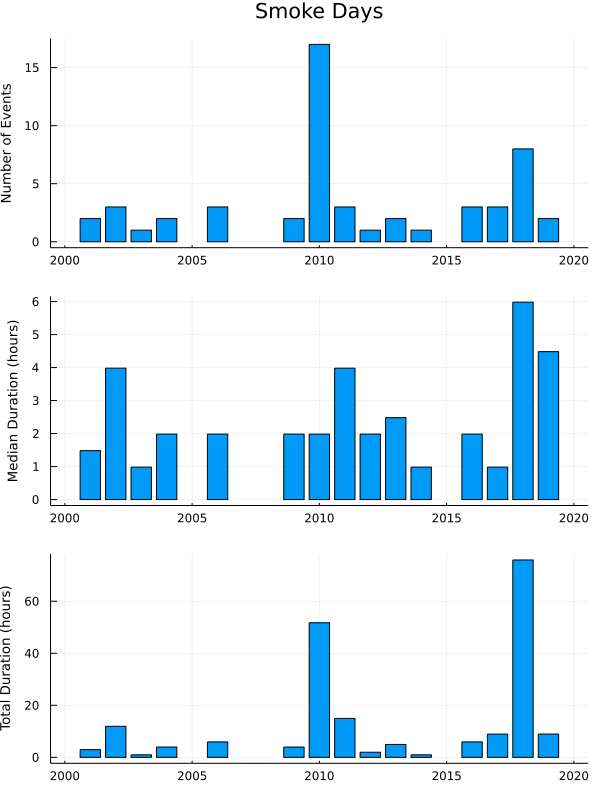

In [9]:
#| echo: false
#| label: fig-smoke-days
#| fig-cap: "Frequency of smoke days in Edmonton, 2001 through 2019"
@pipe result_1hr |>
    groupby(_, :year) |>
    combine(_, nrow, :duration => median => :median, :duration => sum => :total) |>
    begin
        l = @layout [a ; b; c]
        p1 = bar(_.year, _.nrow, lab=false, title="Smoke Days", ylabel="Number of Events", labelfontsize=9)
        p2 = bar(_.year, _.median, lab=false, ylabel="Median Duration (hours)", labelfontsize=9)
        p3 = bar(_.year, _.total, lab=false, ylabel="Total Duration (hours)", labelfontsize=9)
        plot(p1, p2, p3, layout=l, size=(600,800))
    end

One thing these plots may mask is that while the median duration perhaps hasn't changed much, it's clear from the scatter plots that the outlier periods are more common in the last decade than the one preceding it.

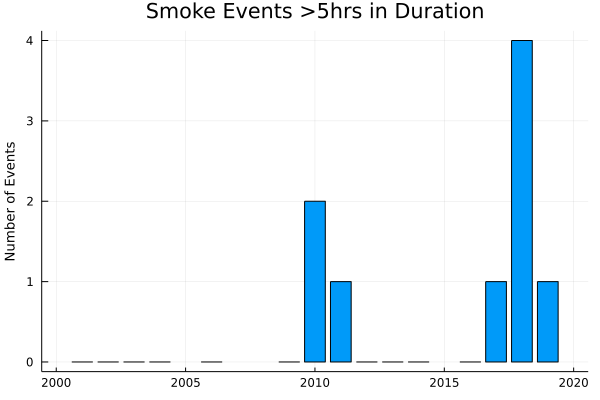

In [10]:
#| echo: false
#| label: fig-duration-5hrs
#| fig-cap: "Frequency of smoke days exceeding 5 hours in duration, Edmonton 2001-2019."

function count_if(vector)
    result = 0
    for r in vector
        if r>5
            result +=1
        end
    end
    return result
end
        

@pipe result_1hr |>
    groupby(_, :year) |>
    combine(_, :duration => count_if => :count) |>
    begin
        bar(_.year, _.count, lab=false, title="Smoke Events >5hrs in Duration", ylabel="Number of Events", labelfontsize=9)
    end

When grouped by month, we can see winter months have notable representation, which is likely those atmospheric inversions trapping pollutants near ground level, but the summer months appears to be when the hazy periods are longest and that likely corresponds to wildfire smoke.

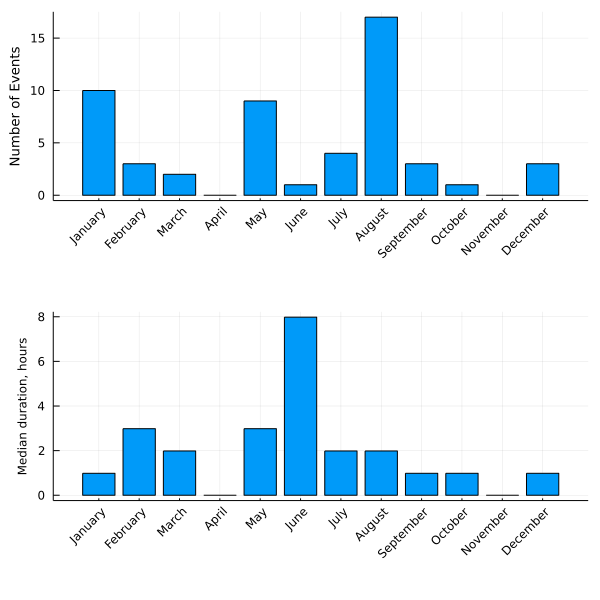

In [11]:
#| echo: false
#| label: fig-monthly
#| fig-cap: "Frequency of smoke events by month, Edmonton 2001-2019"

@pipe result_1hr |>
    groupby(_, :month) |>
    combine(_, nrow, :duration => median => :middle) |>
    begin
        months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        counts = [ if i in _.month sum(_.nrow[ _.month .== i ]) else 0 end for i in 1:12 ]
        meds = [ if i in _.month sum(_.middle[ _.month .== i ]) else 0 end for i in 1:12 ]
        l = @layout [a ; b]
        p1 = bar(months, counts, lab=false, ylabel="Number of Events", labelfontsize=9, xrotation=45)
        p2 = bar(months, meds, lab=false, ylabel="Median duration, hours", labelfontsize=8, xrotation=45)
        plot(p1, p2, layout=l, size=(600,600))
    end

Filtering out only the extended periods, with a duration >5 hrs, we see that prolonged periods of excess pm2.5 appears to be a summer phenomena, especially August. Which is certainly consistent with my experience of noticeable smokey days, corresponding with wildfire season.

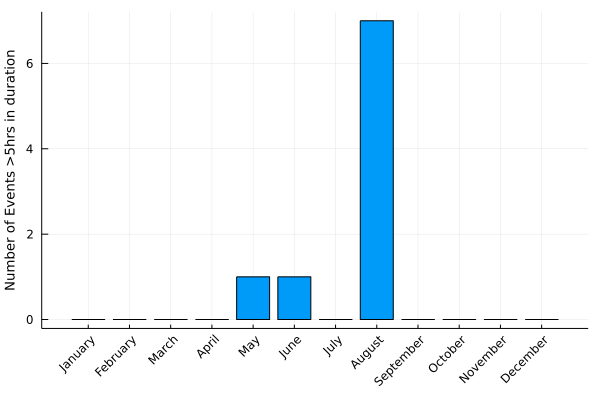

In [12]:
#| echo: false
#| label: fig-monthly-5hr
#| fig-cap: "Frequency of smoke events exceeding 5 hours in duration by month, Edmonton 2001-2019"

@pipe result_1hr |>
    groupby(_, :month) |>
    combine(_, :duration => count_if => :count) |>
    begin
        months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        exceeds = [ if i in _.month sum(_.count[ _.month .== i ]) else 0 end for i in 1:12 ]
        l = @layout [a ; b]
        bar(months, exceeds, lab=false, ylabel="Number of Events >5hrs in duration", labelfontsize=9, xrotation=45)
    end

## Limitations and Opportunities

An opportunity for further analysis would be to look for correlations between pm2.5 and other pollutants, say NOx, to allow one to exclude pm2.5s from vehicle emissions. That would still leave road dust, construction dust, and just farmers burning stubble, but I imagine that would go pretty far in terms of removing unrelated bad air quality days from the dataset. If one was only concerned with the most extreme cases, when the sky turns orange and visibility drops to only a few blocks, well that's visible from space and could presumably be pulled out a dataset of satellite images, taking care to distinguish smoke from cloud cover.

I would like to see a longer dataset. The dataset I was looking at was relatively short, only twenty years, which doesn't allow me to answer the question of whether or not extended periods of wildfire smoke is truly a recent phenomenon versus a "return to normal", i.e. it could be that 2000-2010 were the abnormal years and that is equally consistent with this dataset. Just looking around the air data warehouse it doesn't look like this kind of air analysis was routine before the 2000s, but I could simply be ignorant of some other studies or datasets.

Finally I picked pm2.5s since that is the variable responsible for the high risk AQHI levels, but there could be much better proxies for wildfire smoke that have better datasets. I can't think of anything off the top of my head, but I'm a chemical engineer not an air quality expert.
